# Brain Tumor Segementation using Unet

---

**Motivation:**

The motivation behind this project is driven by the transformative impact that artificial intelligence can have on healthcare, particularly in the field of medical imaging. There's a compelling need to improve the standards of care for patients with brain tumors by leveraging technology to overcome current limitations. The promise of delivering faster, more accurate, and objective assessments of medical images motivates the pursuit of such technological advancements. Furthermore, there is an ethical imperative to enhance medical procedures with tools that can save lives and improve the quality of life for patients. This project embodies the convergence of technology and healthcare, aiming to push the boundaries of what is possible in the early detection and treatment of one of the most challenging medical conditions.


**Purpose:**

The primary purpose of this project is to harness the capabilities of advanced machine learning techniques, specifically the U-Net architecture for convolutional neural networks, to accurately segment brain tumors from MRI scans. The endeavor aims to create a reliable and efficient tool that supports medical professionals by providing precise tumor delineation, which is crucial for diagnosis, treatment planning, and monitoring of brain tumors.

**Importance:**

Brain tumors present a significant challenge due to their life-threatening nature and the complexity involved in their treatment. Early and accurate detection is critical, as it directly influences treatment decisions and patient outcomes. Current methods of tumor segmentation are often time-consuming and rely heavily on the expertise of radiologists. Automating this process with a high degree of accuracy could lead to more consistent and timely diagnoses, reduce the workload on medical staff, and potentially lead to the discovery of new insights through the analysis of segmented tumor data.

The importance of this project is underscored by the potential to:

**Enhance Diagnostic Precision:** Automated segmentation can reduce human error and provide a level of precision that may not be consistently achievable by manual methods.

**Speed Up Diagnosis:** It can significantly reduce the time taken to interpret MRI scans, leading to faster treatment initiation.

**Personalize Treatment:** By offering detailed and accurate measurements of tumor size and growth, the model can contribute to personalized treatment planning that is more effective and less invasive.
Monitor Disease Progression: Automated tools can facilitate more efficient monitoring of tumor evolution over time, crucial for adjusting treatment plans.





## Imports for the Project

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# %%
# import system libs
import os
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import  ModelCheckpoint


/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

2024-04-28 03:14:32.701525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 03:14:32.701628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 03:14:32.866283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# %%

# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

The function uses the glob module to retrieve paths to all mask files in the specified directory and its subdirectories. This is done through the pattern f'{data_dir}/*/*_mask*', which matches any files ending in '_mask' within any subdirectory of data_dir.

the corresponding image path is derived by removing the '_mask' suffix from the filename. This list comprehension transforms each mask path into its corresponding image path, assuming the files are named as expected.

The function constructs a pandas DataFrame named df with two columns:

* images_paths: Contains the paths to the image files.
* masks_paths: Contains the paths to the corresponding mask files.

This DataFrame serves as a consolidated data structure that pairs each image with its respective mask, facilitating easy access and manipulation in subsequent steps of the analysis or processing pipeline.

## Data Preprocessing

In [ ]:
#%%
# Data path
data_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
# Using the function create_df we create a dataframe
df = create_df(data_dir)

## Train,Test,Validate Split

In [ ]:
#%%

train_df, dummy_df = train_test_split(df, train_size= 0.8)


valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

## Data Augumentation

In [ ]:
#%%

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generators(dataframe, augmentation_params):
    # Image and mask sizes
    target_size = (256, 256)
    # Batch size for generator
    batch_size = 40

    # Creating a common ImageDataGenerator for both images and masks
    generator = ImageDataGenerator(**augmentation_params)

    # Setting up image and mask generators
    image_generator = generator.flow_from_dataframe(
        dataframe=dataframe,
        x_col='images_paths',
        class_mode=None,
        color_mode='rgb',
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=None,
        save_prefix='image',
        seed=1
    )

    mask_generator = generator.flow_from_dataframe(
        dataframe=dataframe,
        x_col='masks_paths',
        class_mode=None,
        color_mode='grayscale',
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=None,
        save_prefix='mask',
        seed=1
    )

    # Zip the image and mask generators
    combined_generator = zip(image_generator, mask_generator)

    # Generate pairs and apply post-processing
    for (images, masks) in combined_generator:
        # Normalize images
        images = images / 255.0
        # Binarize masks
        masks = masks / 255.0
        masks[masks > 0.5] = 1
        masks[masks <= 0.5] = 0

        yield (images, masks)

In [ ]:
#%%

# Define augmentation parameters for the training dataset
train_augmentation_params = {
    'rotation_range': 0.2,
    'width_shift_range': 0.05,
    'height_shift_range': 0.05,
    'shear_range': 0.05,
    'zoom_range': 0.05,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

# Create data generators for training, validation, and testing
train_generator = create_generators(train_df, augmentation_params=train_augmentation_params)
valid_generator = create_generators(valid_df, augmentation_params={})
test_generator = create_generators(test_df, augmentation_params={})

1. **Initialization:** Define the target size for the images and masks and the batch size for the generator.
2. **Common Generator:** A single ImageDataGenerator instance is used for both Images and masks. This ensures that the same transformation is applied to both during augmentation, preserving the alignment between each image and its mask.
3. **Image and Mask Generators:** Separate generators for images (image_generator) and masks (mask_generator) are created using the flow_from_dataframe method. These 4. generators read data from a DataFrame where file paths are specified.
4. **Generator Pairing:** The image and mask generators are zipped together to ensure that each batch of images is paired with the corresponding batch of masks.
5. **Post-processing:** In the final step, the images are normalized (dividing by 255.0), and masks are binarized (converting pixel values to 0 or 1 based on a threshold of 0.5), which is typical preprocessing for deep learning models in image segmentation.

* **Training Generator:** Includes data augmentation parameters to introduce variability into the training data, helping to prevent overfitting.
* **Validation and Testing Generators:** Typically do not include augmentation to evaluate the model on unaltered data.

In [ ]:
# %%

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# Function print the Images
def show_images(image_paths, mask_paths, num_images=5):

    # Set the number of images to display to the minimum of num_images or the length of image_paths
    num_images = min(num_images, len(image_paths))

    # Create a figure with subplots
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))

    # If only one image, adjust axes array to be indexable
    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        # Load image
        image = Image.open(image_paths[i])
        mask = Image.open(mask_paths[i])

        # Display image
        axes[i][0].imshow(image)
        axes[i][0].set_title('Image ' + str(i+1))
        axes[i][0].axis('off')  # Turn off axis labels

        # Display mask
        axes[i][1].imshow(mask, cmap='gray')
        axes[i][1].set_title('Mask ' + str(i+1))
        axes[i][1].axis('off')

    plt.tight_layout()
    plt.show()

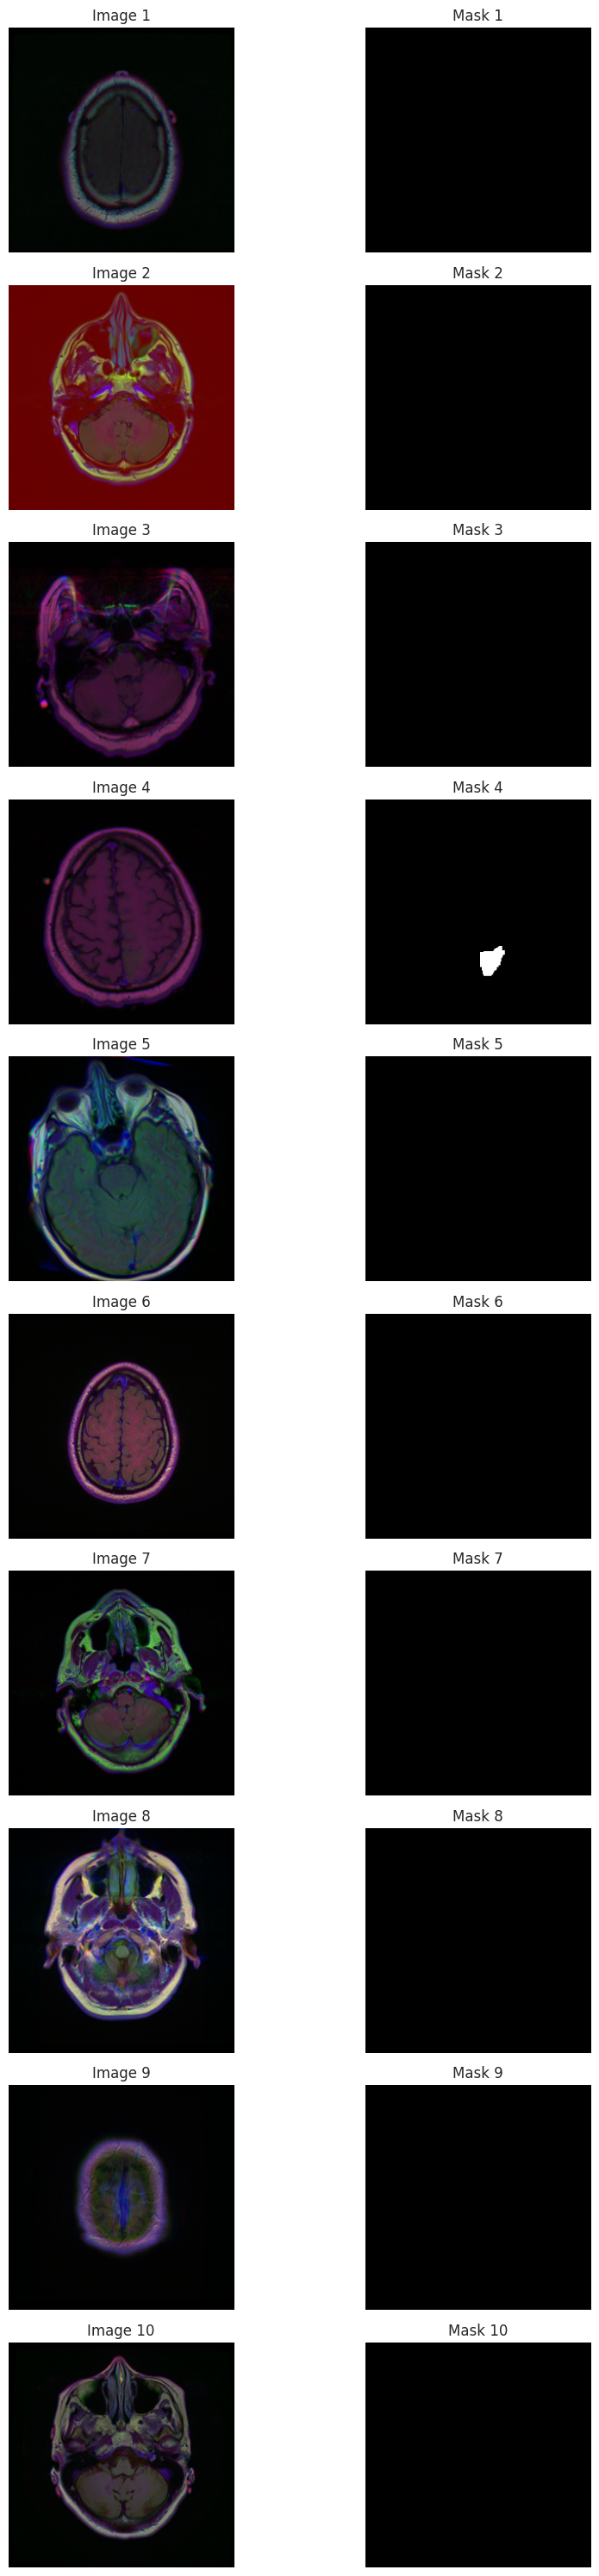

In [ ]:
#%%
show_images(list(train_df['images_paths']), list(train_df['masks_paths']), num_images=10)

Above are the images of the data images(MRI) and there respective masks

In [ ]:
#%%

# Count the number of images and masks and verify matching pairs
def count_and_verify_images_masks(data_df, dataset_type):
    num_images = len(data_df['images_paths'])
    num_masks = len(data_df['masks_paths'])

    if num_images != num_masks:
        print(f"Warning: Number of images and masks do not match in {dataset_type} dataset!")

    mismatch_count = 0
    # Iterate over the DataFrame to check each image-mask pair
    for img_path, mask_path in zip(data_df['images_paths'], data_df['masks_paths']):
        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            print(f"Missing file: {img_path} or {mask_path}")
            mismatch_count += 1
        else:
            # Optionally add more sophisticated checks here if necessary
            pass

    print(f"Number of {dataset_type} images: {num_images}")
    print(f"Number of {dataset_type} masks: {num_masks}")
    print(f"Number of mismatches in {dataset_type}: {mismatch_count}")

# Example usage for training, validation, and test datasets
count_and_verify_images_masks(train_df, "training")
count_and_verify_images_masks(valid_df, "validation")
count_and_verify_images_masks(test_df, "test")

Number of training images: 3143
Number of training masks: 3143
Number of mismatches in training: 0
Number of validation images: 393
Number of validation masks: 393
Number of mismatches in validation: 0
Number of test images: 393
Number of test masks: 393
Number of mismatches in test: 0


The Number of images is counted and also validated if the masks and the images are macthing after we checked there are no mistaches of images and masks in either if training test and Validation

In [ ]:
#%%\

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return Model(inputs=[inputs], outputs=[outputs])

# Create the model
model = unet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_8[0][0]  

 Total params: 471,553 (1.80 MB)

 Trainable params: 471,553 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

**Input Layer:**

The network accepts an input size of 256x256 pixels with 3 channels (e.g., RGB color channels in an image). This is defined by input_size=(256, 256, 3).

**Encoder (Downsampling Path):**

* The encoder consists of two convolutional blocks. Each block has two convolutional layers with ReLU activation functions. The convolutional layers in the first block have 32 filters of size 3x3, while the second block has 64 filters of the same size. Both blocks use 'same' padding to preserve the spatial dimensions after convolution.
* After each convolutional block, a 2x2 max pooling layer is applied to reduce the spatial dimensions by half, thereby downsampling the feature maps and increasing the field of view for the subsequent layers.

**Bottleneck:**

* The bottleneck serves as the bridge between the encoder and decoder parts of the network. It is made up of two convolutional layers, each with 128 filters of size 3x3 and ReLU activation. The bottleneck does not change the dimensionality, focusing instead on developing a rich feature representation of the input data at the reduced resolution.

**Decoder (Upsampling Path):**

* The decoder is symmetrical to the encoder and consists of two upsampling blocks. The upsampling is achieved using 2x2 UpSampling2D layers, which increase the spatial dimensions of the feature maps.
* Each upsampling layer is followed by a concatenation with the corresponding feature map from the encoder path (skip connection), which combines high-level features (from the bottleneck) with high-resolution features (from the encoder). This is essential for precise localization in the segmentation map.
* Following the concatenation, each block has two convolutional layers with ReLU activation. The first block of the decoder path reduces the number of filters to 64, and the second block reduces them further to 32.

**Output Layer:**

* The final layer of the network is a convolutional layer with a single filter of size 1x1, using a sigmoid activation function. This layer outputs the probability of each pixel belonging to the target class (e.g., tumor) in the form of a binary segmentation map.

The architecture is then compiled into a Keras Model, with the inputs specified as the input layer and outputs as the final layer of the network. 



In [ ]:
#%%

# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

1. **Dice Coefficient**

The Dice Coefficient, also known as the Sørensen-Dice index, is a statistical tool that measures the similarity between two samples. It is particularly useful in the field of image segmentation to gauge the accuracy of the predictions. The formula provided in the function dice_coef

2. **Dice Loss**

Dice Loss is a loss function based on the Dice Coefficient, used to train models like U-Net for segmentation tasks. It is defined as the negative of the Dice Coefficient to convert it into a minimization problem

3. **Intersection over Union (IoU) Coefficient**

IoU, also known as the Jaccard Index, is another statistical measure used to quantify the percent overlap between the target mask and the prediction output.

In [ ]:
#%%

model = unet()
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_11[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_13[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_15[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 128, 128,  │          0 │ conv2d_16[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 192)              │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │    110,656 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 256, 256,  │          0 │ conv2d_18[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 256,  │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 96)               │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │     27,680 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_19[0][0] 

 Total params: 471,553 (1.80 MB)

 Trainable params: 471,553 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# %%

#Model training

epochs = 20
batch_size = 16
callbacks = [ModelCheckpoint('unet.keras', verbose=1, save_best_only=True)]
history = model.fit(
    train_generator,
    steps_per_epoch=int(len(train_df) / batch_size),  # Convert to integer
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_generator,
    validation_steps=int(len(valid_df) / batch_size)  # Convert to integer
    )

Epoch 1/20
 48/196 ━━━━━━━━━━━━━━━━━━━━ 2:55 1s/step - accuracy: 0.9736 - dice_coef: 0.3363 - iou_coef: 0.2109 - loss: -0.3363

2024-04-28 03:20:01.291595: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,96,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,96,256,256]{3,2,1,0}, f32[23,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-28 03:20:02.868391: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.576881205s
Trying algorithm eng0{} for conv (f32[32,96,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,96,256,256]{3,2,1,0}, f32[23,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-28 03:20:06.591505: E external/

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9824 - dice_coef: 0.4106 - iou_coef: 0.2692 - loss: -0.4112Found 393 validated image filenames.
Found 393 validated image filenames.


2024-04-28 03:22:43.081430: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[33,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[33,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-28 03:22:43.517084: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.435744899s
Trying algorithm eng0{} for conv (f32[33,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[33,96,256,256]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2


Epoch 1: val_loss improved from inf to -0.54352, saving model to unet.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.9824 - dice_coef: 0.4109 - iou_coef: 0.2694 - loss: -0.4115 - val_accuracy: 0.9892 - val_dice_coef: 0.5443 - val_iou_coef: 0.3810 - val_loss: -0.5435
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.9902 - dice_coef: 0.5045 - iou_coef: 0.3502 - loss: -0.5041
Epoch 2: val_loss improved from -0.54352 to -0.60422, saving model to unet.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 159s 811ms/step - accuracy: 0.9902 - dice_coef: 0.5046 - iou_coef: 0.3503 - loss: -0.5042 - val_accuracy: 0.9916 - val_dice_coef: 0.6042 - val_iou_coef: 0.4411 - val_loss: -0.6042
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.9906 - dice_coef: 0.5334 - iou_coef: 0.3758 - loss: -0.5336
Epoch 3: val_loss improved from -0.60422 to -0.61738, saving model to unet.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 158s 807ms/step - accuracy: 0.9906 - dice_coef: 0.5335 - iou_

**Training and Validation Trends**

**Steady Progress:** Both training and validation metrics show a general improvement, suggesting that the model is not experiencing significant overfitting. The validation metrics closely follow the training metrics, which is an encouraging sign of the model's ability to generalize.

**Model Checkpoints:** The model checkpoints save the best model based on the validation loss. Throughout the epochs, whenever there is an improvement in validation loss, the model is saved. This ensures that the best-performing model is retained.

**Training Stability:** The progression of metrics appears stable without large fluctuations, indicating that the learning rate and model architecture are well-suited to the task.

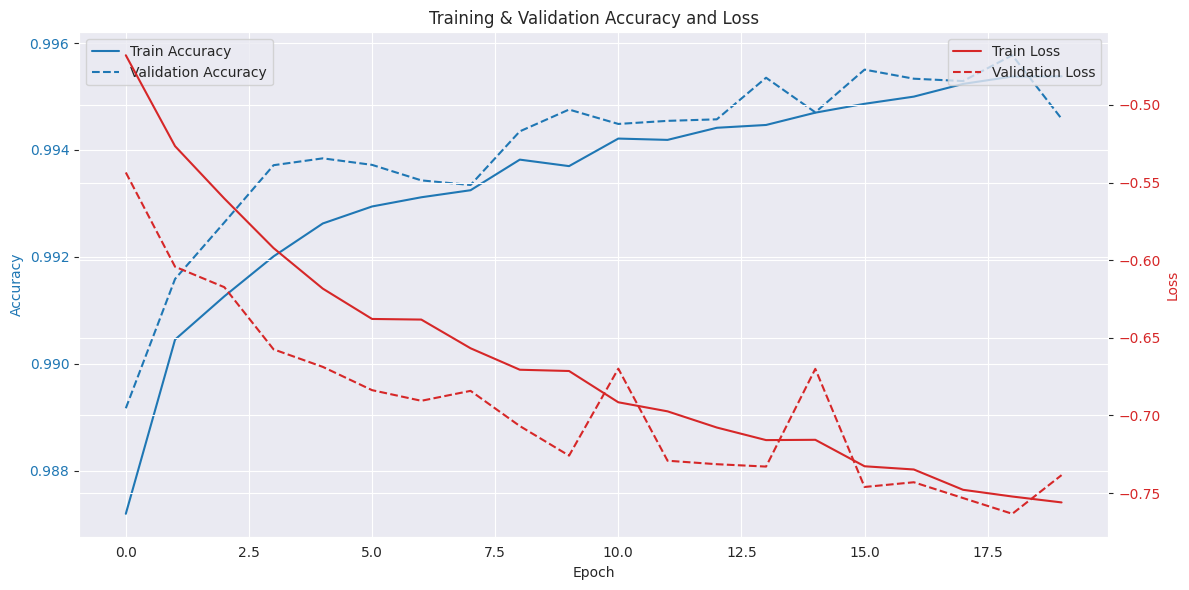

In [ ]:
# %%

#Chart
import matplotlib.pyplot as plt

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the accuracy on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(history.history['accuracy'], color=color, label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], color=color, linestyle='dashed', label='Validation Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Create a second y-axis for the loss with shared x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Loss', color=color)
ax2.plot(history.history['loss'], color=color, label='Train Loss')
ax2.plot(history.history['val_loss'], color=color, linestyle='dashed', label='Validation Loss')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Title and layout adjustments
plt.title('Training & Validation Accuracy and Loss')
fig.tight_layout()

# Show plot
plt.show()

**Accuracy Trend:**

The training accuracy (solid blue line) increases steadily as epochs progress, indicating the model is learning effectively from the training data. Validation accuracy (dashed blue line) also increases, with minor fluctuations, and closely follows the training accuracy trend. This close tracking suggests that the model is generalizing well to unseen data.

**Loss Trend:**

The training loss (solid red line) and validation loss (dashed red line) both decrease over time, which is expected in a well-functioning model. The validation loss exhibits more significant variability than the training loss, which is common due to variations in the validation dataset that the model hasn't seen during training.

In [ ]:
# %%

# Model Evaluation
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model on the train, validation, and test sets
train_score = model.evaluate(train_generator, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_generator, steps=test_steps, verbose=1)
test_score = model.evaluate(test_generator, steps=test_steps, verbose=1)

# Output the results for training, validation, and testing
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 766ms/step - accuracy: 0.9942 - dice_coef: 0.7293 - iou_coef: 0.5804 - loss: -0.7291
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.9946 - dice_coef: 0.7420 - iou_coef: 0.5936 - loss: -0.7420
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step - accuracy: 0.9951 - dice_coef: 0.7597 - iou_coef: 0.6167 - loss: -0.7598
Train Loss:  -0.7344985604286194
Train Accuracy:  0.9943835139274597
Train IoU:  0.5867845416069031
Train Dice:  0.7349539995193481
--------------------
Valid Loss:  -0.7436373233795166
Valid Accuracy:  0.9945980310440063
Valid IoU:  0.5971008539199829
Valid Dice:  0.7440433502197266
--------------------
Test Loss:  -0.7594009041786194
Test Accuracy:  0.995166003704071
Test IoU:  0.6156193614006042
Test Dice:  0.758823573589325


**Training Metrics:**

* **Train Loss:** The negative value of the training loss is expected because the dice loss is calculated as the negative of the dice coefficient. A lower dice loss (more negative) indicates better performance, as the dice coefficient is being maximized.
* **Train Accuracy:** The model has achieved high accuracy (99.44%), which typically suggests excellent performance. However, for segmentation tasks, accuracy can sometimes be misleading, particularly if the class distribution is imbalanced (in our case more background than tumor pixels).
* **Train IoU:** The Intersection over Union (IoU) score of approximately 58.68% suggests moderate performance. IoU is a crucial metric for segmentation because it measures the overlap between the prediction and ground truth.
* **Train Dice Coefficient:** A dice coefficient of approximately 73.50% is good, as it reflects the model's effectiveness at segmenting the tumors, considering both precision and recall.

**Validation Metrics:**

* **Valid Loss:** Consistency between the training and validation dice loss (-0.7436) indicates that the model generalizes well to unseen data, at least to the extent of the validation set.
* **Valid Accuracy:** A very high validation accuracy (99.46%) aligns with the training accuracy, again suggesting good model generalization.
* **Valid IoU:** An IoU of approximately 59.71% on the validation set indicates a reasonable overlap and is slightly better than the training IoU.
* **Valid Dice Coefficient:** With a validation dice score of about 74.40%, the model maintains a good level of performance on the validation dataset.

*&Test Metrics:**

* **Test Loss:** The test loss (-0.7594) is the most negative, indicating that the test set dice coefficient is the highest among the three datasets.
* **Test Accuracy:** The accuracy on the test set (99.52%) is exceptionally high, suggesting that the model segments the test images very well.
* **Test IoU:** The test IoU score of 61.56% is the highest, showing better performance on the test set compared to the training and validation sets.
* **Test Dice Coefficient:** The test dice score is around 75.88%, which is the highest dice coefficient among the three datasets, suggesting that the model achieves the best segmentation performance on the test set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


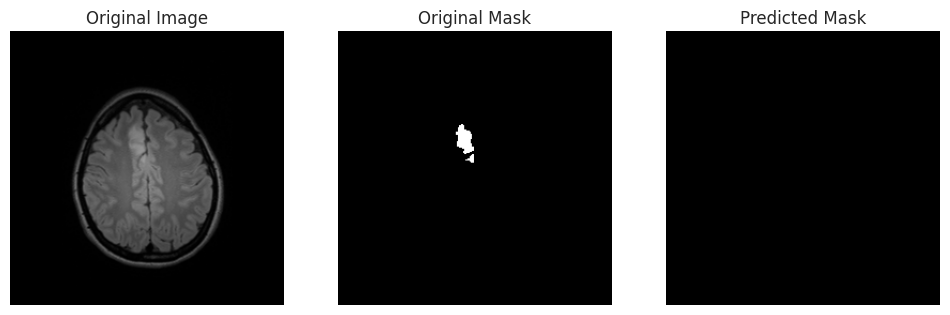

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


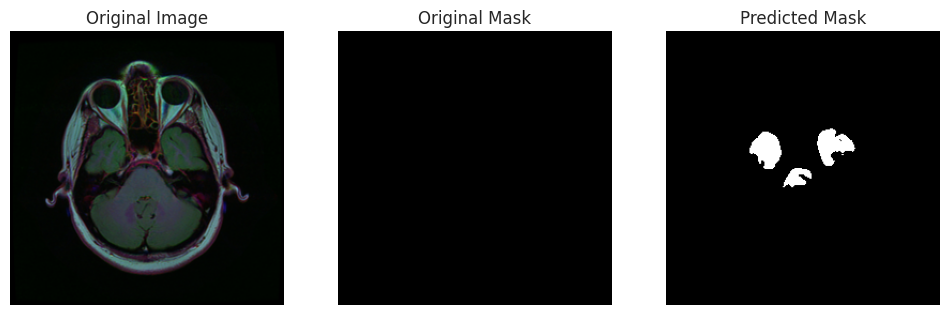

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


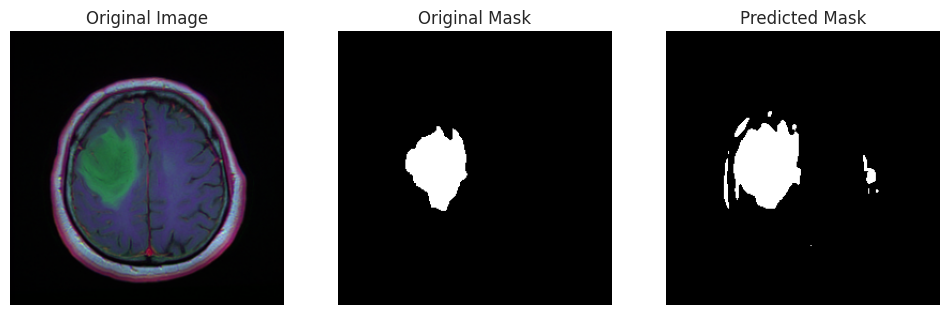

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


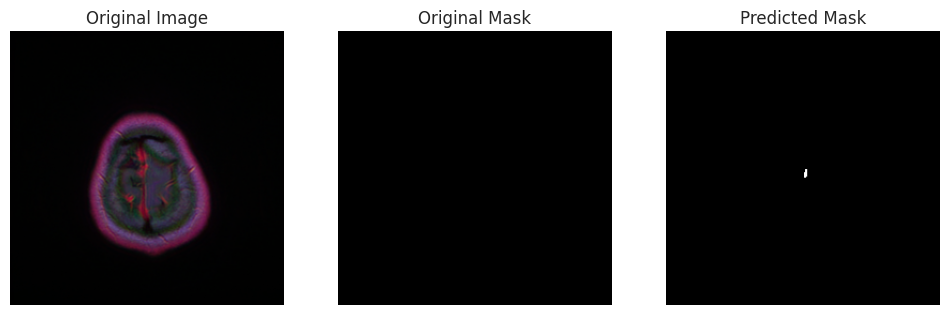

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


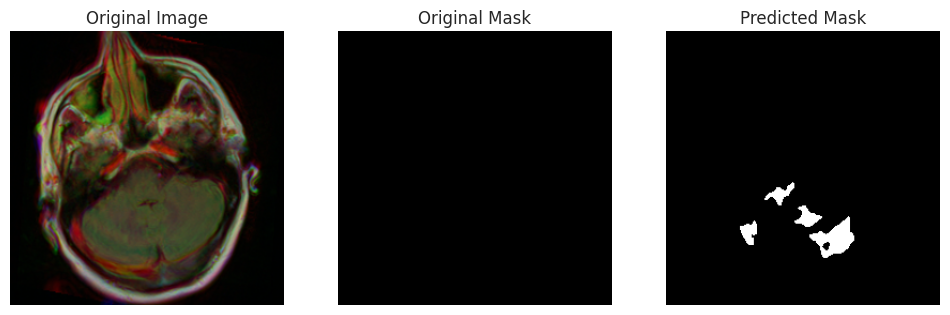

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


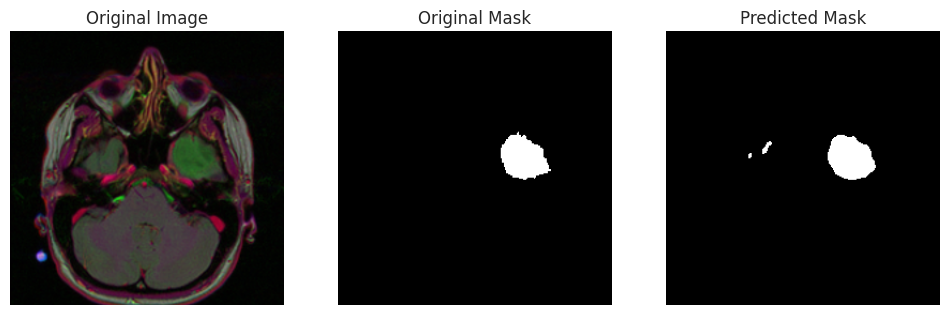

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


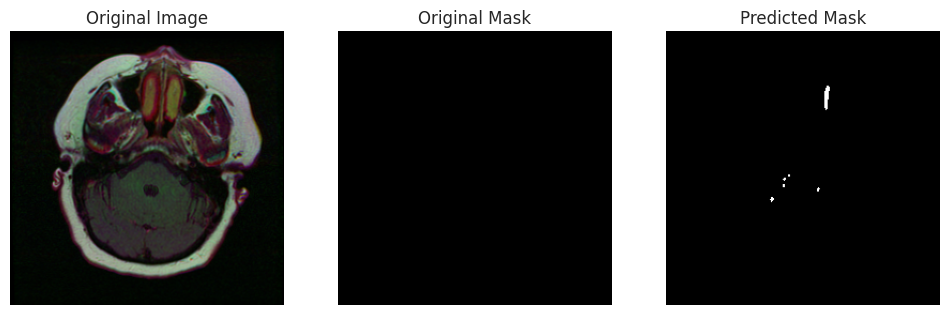

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


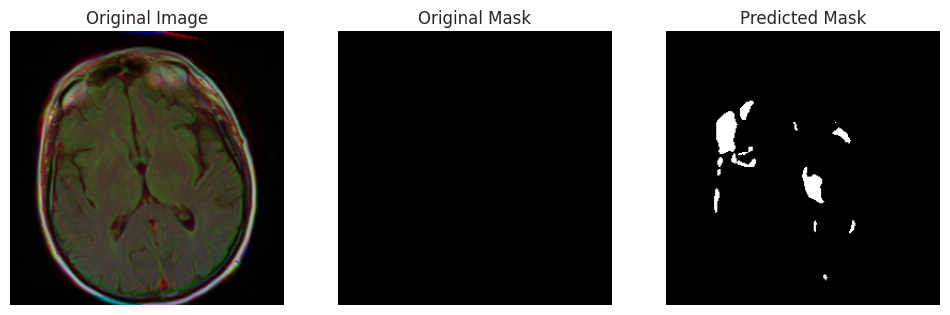

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


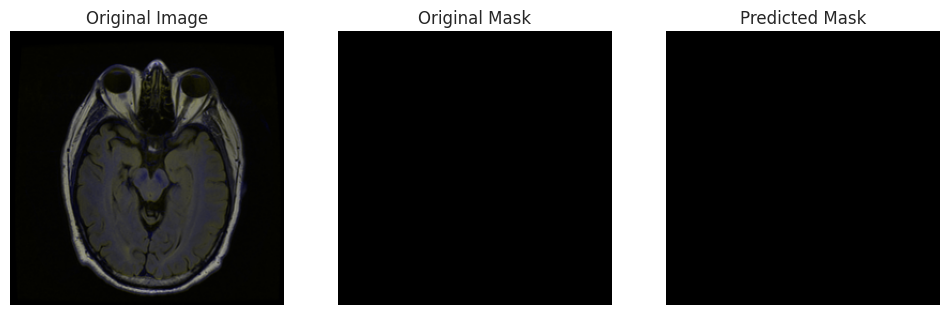

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


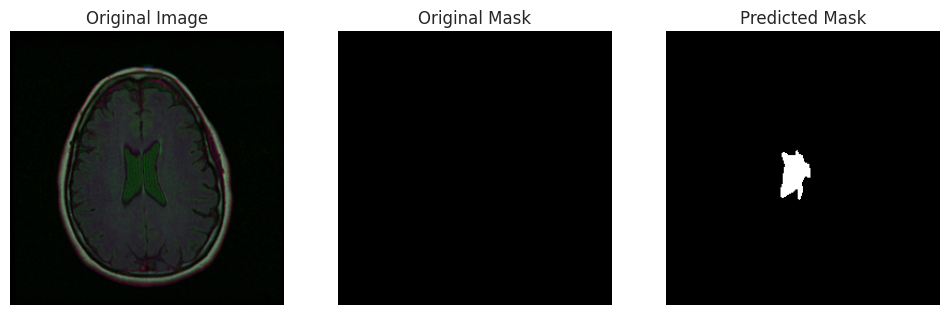

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


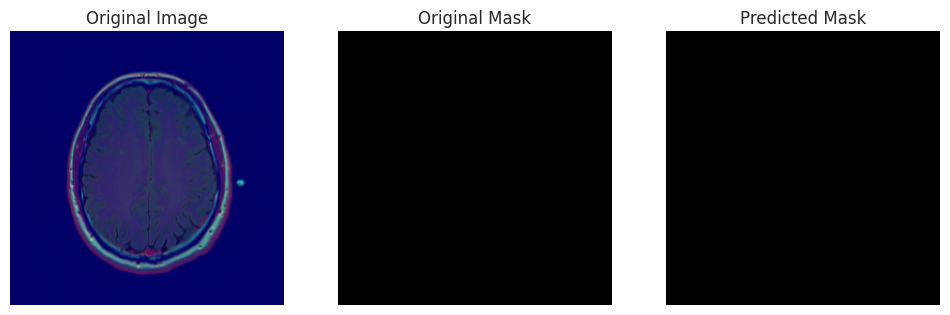

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


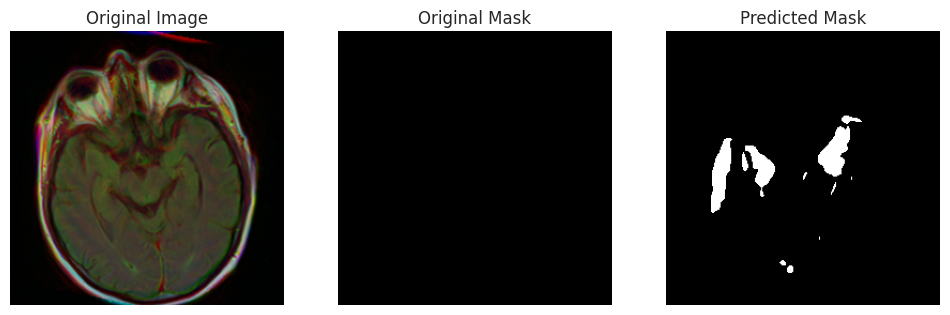

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


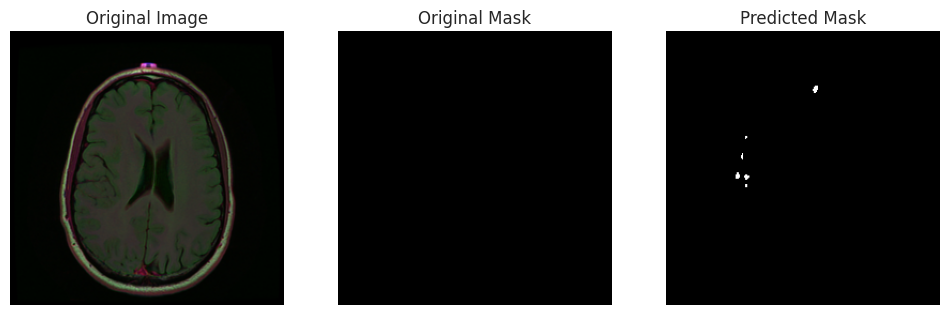

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


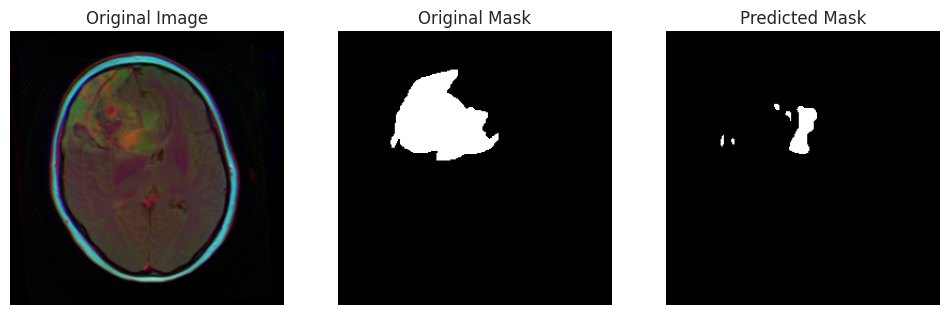

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


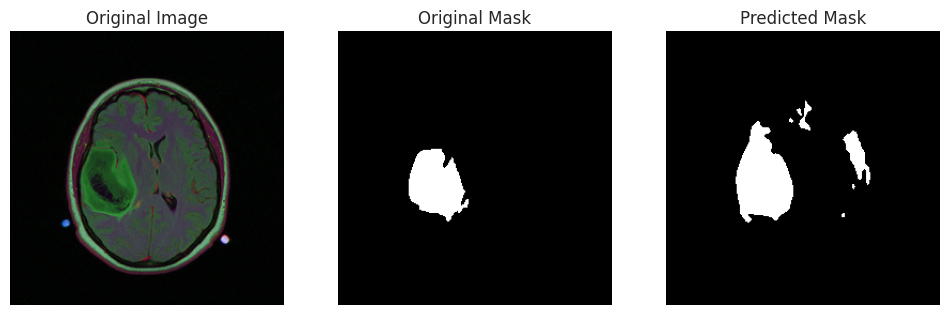

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


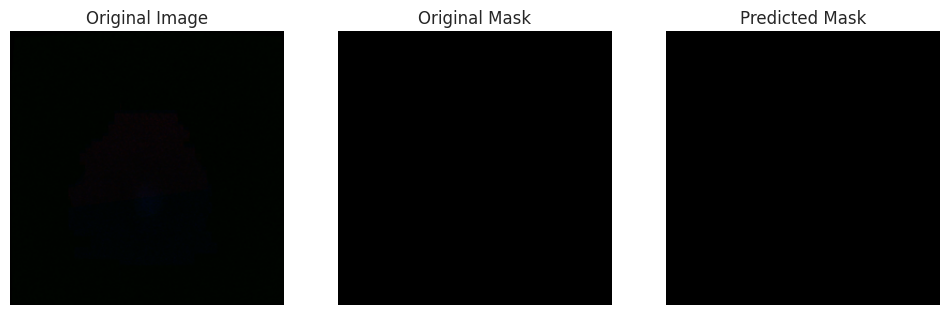

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


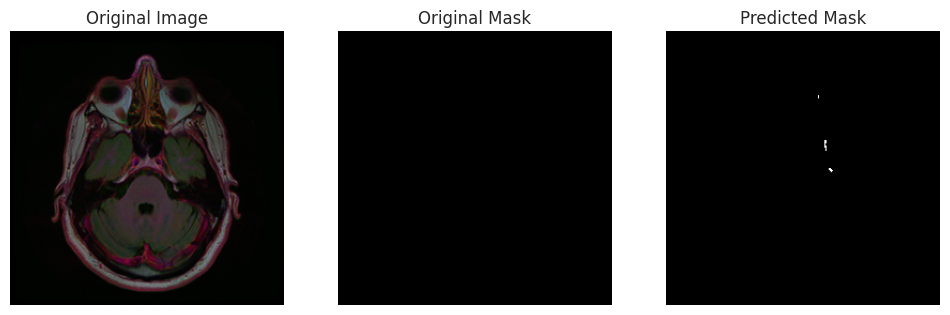

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


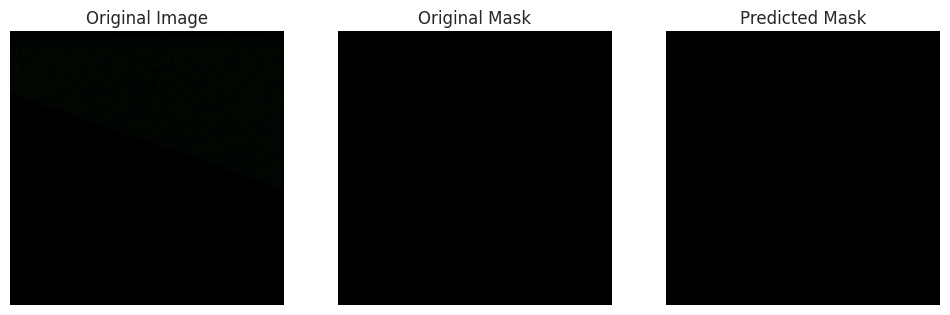

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


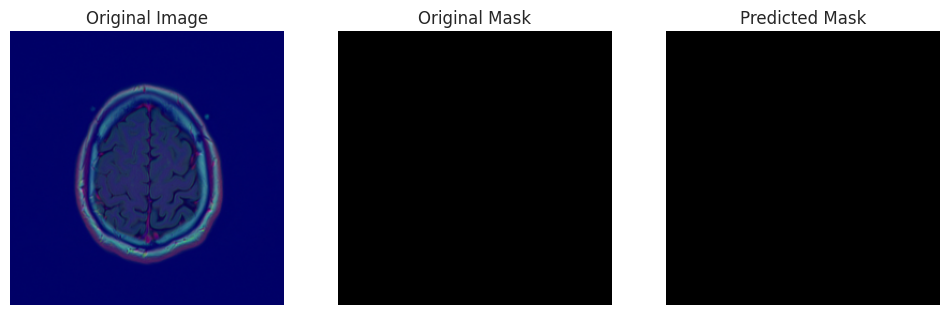

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


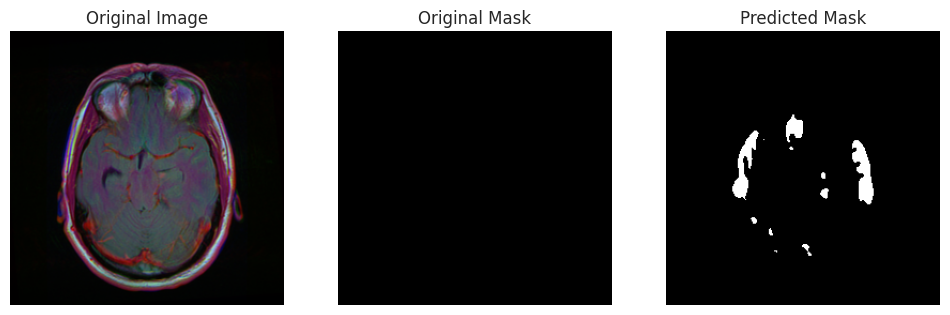

In [ ]:
#%%

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Iterate over random samples from the test set
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255.0
    img = img[np.newaxis, :, :, : ]

    predicted_mask = model.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.imread(test_df['masks_paths'].iloc[index], cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_mask) > 0.5, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

These are masks predicted by the model, Left side image is the MRI scan image center image is the Original Mask and the right side image is the Predicetd mask

**Conclusion:**

The employment of U-Net, a powerful convolutional neural network tailored for medical image segmentation, has been instrumental in the promising results achieved in this brain tumor segmentation project. With commendable accuracy, Intersection over Union (IoU), and Dice coefficients, the model has demonstrated its potential in precisely delineating tumor boundaries from MRI scans. These metrics signify the model's capability to capture the intricate spatial relationships and variability inherent in medical imaging, which is vital for accurate tumor identification.


**Future Scope:**

1. Dataset Enrichment: Further enlargement and diversification of the dataset are essential. Including a wider array of tumor types, stages, and imaging conditions will help in training a model that is robust and generalizable across different clinical settings.

2. Advanced U-Net Variants: Exploration of enhanced U-Net variants, such as attention U-Net or multi-scale U-Net, could offer further improvements in segmentation precision and computational efficiency.

3. Clinical Integration and Testing: Building a pipeline for seamless integration of the segmentation model into the clinical workflow is critical. In parallel, pilot clinical studies could be conducted to assess the model's impact on diagnostic accuracy and treatment planning.

4. Automated Post-Processing: Investigating automated techniques for post-processing the segmented images could refine the output, reduce manual interventions, and streamline the workflow for clinicians.



